In [1]:
!pip list |grep jijmodeling 
!pip list |grep jupyter

jijmodeling                    1.0.3
jijmodeling-schema             0.2.0
jijmodeling-transpiler         0.6.0rc3
jijmodeling-transpiler-quantum 0.1.0rc3    /home/quantumuser/JijModelingTranspilerQuantum
jupyter                        1.0.0
jupyter_client                 8.3.0
jupyter-console                6.6.3
jupyter_core                   5.3.1
jupyter-events                 0.7.0
jupyter-lsp                    2.2.0
jupyter_server                 2.7.0
jupyter_server_terminals       0.4.4
jupyterlab                     4.0.3
jupyterlab-pygments            0.2.2
jupyterlab_server              2.24.0
jupyterlab-widgets             3.0.8


# Tutorial for MaxCut problem using QRAO

## QRAO for MaxCut
With `transpiler_qiskit`, you can convert not only to Ising Hamiltonian, but also to QRAO HAmiltonian. In this note, we will actually convert to QRAO Hamiltonian and perform a VQE. This Algorithm is based on Fuller et al.(2021)

In [2]:
import jijmodeling as jm
import jijmodeling_transpiler as jmt
import jijmodeling_transpiler_quantum.quri_parts as jmqq
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import jijmodeling as jm
def maxcut_problem():
    N = jm.Placeholder('N')
    E = jm.Placeholder('E', ndim=2)
    x = jm.BinaryVar('x', shape=(N,))
    e = jm.Element('e', belong_to=E)

    s_i = 1 - 2*x[e[0]]
    s_j = 1 - 2*x[e[1]]
    s_i.set_latex('s_i') 
    s_j.set_latex('s_j')
    
    problem = jm.Problem('MAXCUT')
    problem += -1/2 * jm.sum(e, 1 - s_i*s_j)
    return problem

problem = maxcut_problem()

## 3-regular Graph
Here we want to solve a 16-node 3regular graph as an example.

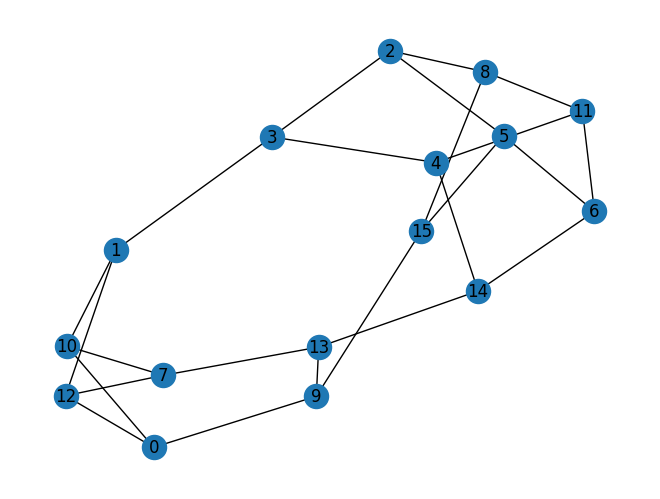

In [4]:
num_nodes = 16
G = nx.random_regular_graph(3, num_nodes,seed=42)

nx.draw(G, with_labels=True)
instance_data = {'E': [list(edge) for edge in G.edges], 'N': num_nodes}

### Transpile to QRAO Hamiltonian
Transpiling to the QRAC Hamiltonian can be done in much the same way as transpiling to the Ising Hamiltonian.

In [5]:
compiled_instance = jmt.core.compile_model(problem, instance_data)

qrac_builder = jmqq.qrao.transpile_to_qrac31_hamiltonian(compiled_instance, normalize=False)

qrac_hamiltonian, offset, encoding_cache = qrac_builder.get_hamiltonian()

### Check the Circuit
We can check the information from the transpiled QRAO Hamiltonian

In [6]:
num_qubit=len(encoding_cache.color_group)
print("num_qubit: ", num_qubit)
print("Qrac hamiltonian: ",qrac_hamiltonian)
print("The color group: ", encoding_cache.color_group)
print("offset: ", offset)
print(f"The compression ration : {num_nodes/num_qubit}")

num_qubit:  6
Qrac hamiltonian:  1.5*Z0 Z1 + 1.5*Z0 X1 + 1.5*Z0 Y1 + 1.5*X0 Z1 + 1.5*Y0 Z1 + 1.5*Z2 Z3 + 1.5*Y1 Z2 + 1.5*Y0 Z2 + 1.5*X2 Z3 + 1.5*Y2 Z3 + 1.5*Y1 X2 + 1.5*X2 X3 + 1.5*X1 Y3 + 1.5*X1 Z4 + 1.5*Y3 Z5 + 1.5*Y3 X5 + 1.5*X0 X4 + 1.5*X4 Z5 + 1.5*Y2 X4 + 1.5*X0 X3 + 1.5*Y0 X3 + 1.5*Z4 Z5 + 1.5*Z4 X5 + 1.5*Y2 X5
The color group:  {0: [0, 4, 5], 1: [1, 2, 3], 2: [6, 8, 9], 3: [7, 10, 11], 4: [12, 15], 5: [13, 14]}
offset:  -12.0
The compression ration : 2.6666666666666665


### Run VQE
Now we also obtain the VQE results. Due to the small size of the problem, we can also calculate the exact solution. Here, we also compute the exact solution for the Ising Hamiltonian to compare the results.

In [7]:
from quri_parts.core.state import ComputationalBasisState, ParametricCircuitQuantumState
from quri_parts.qulacs.estimator import create_qulacs_vector_parametric_estimator
from quri_parts.algo.ansatz import HardwareEfficient

hw_ansatz = HardwareEfficient(qubit_count=num_qubit, reps=1)
estimator = create_qulacs_vector_parametric_estimator()

def cost_fn(param_values):
    estimate = estimator(hamiltonian, parametric_state, param_values)
    return estimate.value.real

In [8]:
from scipy.optimize import minimize

hamiltonian=qrac_hamiltonian
init_params = [0.1] * hw_ansatz.parameter_count
parametric_state = ParametricCircuitQuantumState(num_qubit, hw_ansatz)

optimization_history=[]
result = minimize(cost_fn,
                  init_params, options={'maxiter':100000, 'tol':0.01},
                  method='COBYLA',
                  callback = lambda x:optimization_history.append(cost_fn(x)))

print(result.message)
print("Optimized value:", result.fun)
print("Optimized parameter:", result.x)
print("Cost function calls:", result.nfev)

Optimization terminated successfully.
Optimized value: -12.444991390738572
Optimized parameter: [-1.97547454  1.06595216 -2.31504119  0.46761046  0.03600846 -0.39204889
  0.07961407 -0.84238704  2.1842159   1.00335176  0.50320541  0.17816414
 -1.10409744 -0.96569032 -0.77131983 -1.01405866  1.04439898  0.59924396
  2.29539213 -2.31397721 -0.07556358  2.18227046  0.05326192  3.01371235]
Cost function calls: 1176


Text(0, 0.5, 'cost function')

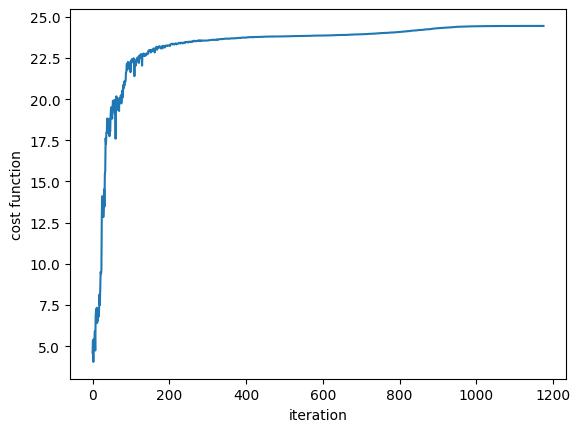

In [9]:
plt.plot(-(np.array(optimization_history)+offset))
plt.xlabel('iteration')
plt.ylabel('cost function')

In [10]:
from quri_parts.qulacs.circuit import convert_circuit as convert_circuit_qulacs
import qulacs
from quri_parts.core.operator import pauli_label
from quri_parts.core.operator import PAULI_IDENTITY
from quri_parts.core.operator import Operator


encoded_op = encoding_cache.encoding
n_qubit = len(encoding_cache.color_group)
sorted_op = sorted(encoded_op.items())
variable_ops_str = [jmqq.qrao.qrao31.create_pauli_term([pauli_kind], [color], n_qubit) for idx,(color,pauli_kind) in sorted_op]
num_variables = len(variable_ops_str)
print(variable_ops_str)

variable_ops=Operator()
for op in variable_ops_str:
    variable_ops+=Operator({pauli_label(op):1})
    
estimator = create_qulacs_vector_parametric_estimator()
hamiltonian=variable_ops
hw_ansatz=HardwareEfficient(qubit_count=n_qubit, reps=1)
parametric_state = ParametricCircuitQuantumState(n_qubit, hw_ansatz)
estimate_result = estimator(hamiltonian, parametric_state, result.x)

bind_hw_ansatz_opt=hw_ansatz.bind_parameters(result.x)
qulacs_circuit_opt = convert_circuit_qulacs(bind_hw_ansatz_opt)

qulacs_state = qulacs.QuantumState(n_qubit)
qulacs_circuit_opt.update_quantum_state(qulacs_state)
probs = np.abs(qulacs_state.get_vector())**2
print(probs)

rng = np.random.default_rng()
def sign(val) -> int:
    return 1 if (val > 0) else 0
rounded_vars = [sign(e) if not np.isclose(0, e) else rng.choice([0,1]) for e in probs]


['Z0', 'Z1', 'X1', 'Y1', 'X0', 'Y0', 'Z2', 'Z3', 'X2', 'Y2', 'X3', 'Y3', 'Z4', 'Z5', 'X5', 'X4']
[3.35842539e-03 5.16862632e-03 1.02726486e-02 6.07480438e-03
 1.11718810e-03 1.70397587e-03 3.09544831e-03 1.89501237e-03
 1.85141642e-02 2.83568128e-02 5.64075980e-02 3.34584968e-02
 6.09902507e-03 9.43840852e-03 1.71050045e-02 1.03674291e-02
 1.42847836e-02 2.18223406e-02 4.33912920e-02 2.57867392e-02
 4.68100328e-03 7.30092872e-03 1.32520016e-02 7.98171219e-03
 6.11081456e-02 9.37370817e-02 1.86446966e-01 1.10479917e-01
 2.01927240e-02 3.11058795e-02 5.63802031e-02 3.42872001e-02
 2.26328953e-04 3.48270059e-04 6.93019854e-04 4.09719727e-04
 7.52682805e-05 1.14852363e-04 2.07836403e-04 1.27360056e-04
 1.32235495e-03 2.02549505e-03 4.02817691e-03 2.38939053e-03
 4.35675989e-04 6.74080839e-04 1.22254128e-03 7.40919213e-04
 7.88486262e-04 1.20501106e-03 2.39530702e-03 1.42323815e-03
 2.58584351e-04 4.02837881e-04 7.31873233e-04 4.41059614e-04
 3.35952455e-03 5.15289928e-03 1.02501378e-02 6.0